<a href="https://www.kaggle.com/code/swish9/weather-image-recognition-model?scriptVersionId=184557951" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color: #87CEEB; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🌦️ Introduction
</div>

**This notebook explores the task of weather image classification using deep learning techniques. The dataset used for this project is sourced from Kaggle, containing 6862 images categorized into 11 different weather classes including dew, fog/smog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, and snow. The goal is to develop and compare multiple models for weather classification: starting with a custom convolutional neural network (CNN), followed by fine-tuning popular pre-trained models such as VGG16, ResNet50, and DenseNet using TensorFlow and other essential libraries. The project aims to achieve robust classification performance through both custom model architecture and leveraging transfer learning techniques.**

<div style="background-color: #4682B4; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  📚 Importing Libraries and Data
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing and visualization
from PIL import Image
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, LeakyReLU, Lambda
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-learn forpreprocessing and  metrics and evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [3]:
data_dir = '/kaggle/input/weather-dataset/dataset'

batch_size = 32
img_height = 128
img_width = 128

In [4]:
dataset = image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    verbose=True,
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

Found 6862 files belonging to 11 classes.


<div style="background-color: #1E90FF; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🔍 Exploratory Data Analysis (EDA)
</div>

In [5]:
class_images = {class_name: [] for class_name in dataset.class_names}

In [6]:
for images, labels in dataset.take(len(dataset)):
    for img, label in zip(images, labels):
        class_name = dataset.class_names[label]
        if len(class_images[class_name]) < 8:
            class_images[class_name].append(img)
        if all(len(imgs) == 8 for imgs in class_images.values()):
            break
    if all(len(imgs) == 8 for imgs in class_images.values()):
        break

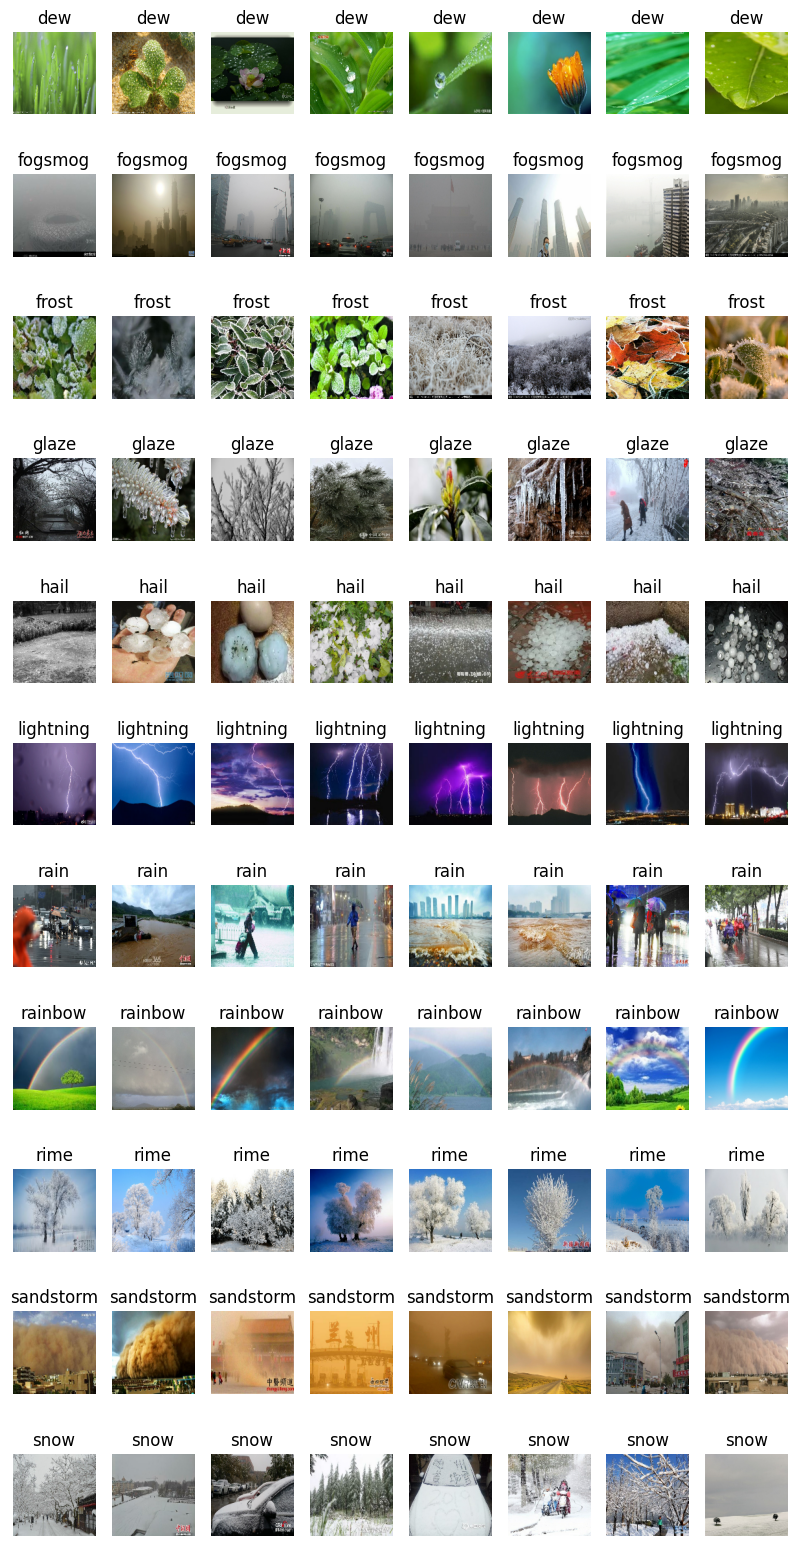

In [7]:
plt.figure(figsize=(10, 20))
i = 0
for class_name, images in class_images.items():
    for img in images:
        i += 1
        plt.subplot(len(dataset.class_names), 8, i)
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis('off')
plt.show()

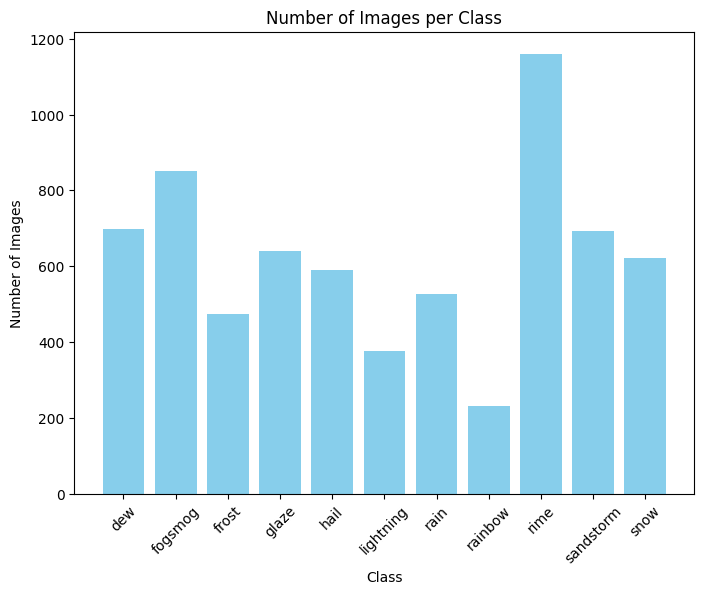

In [8]:
class_counts = {class_name: 0 for class_name in dataset.class_names}
for images, labels in dataset:
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Bar plot of image counts per class
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)
plt.show()

> Dataset Seems to be highly imbalanced 

In [9]:
def extract_color_histograms(images):
    red_hist = []
    green_hist = []
    blue_hist = []

    for image in images:
        image = image.numpy().astype(np.uint8)
        
        hist_red = np.histogram(image[:,:,0], bins=256, range=[0, 256])[0]
        hist_green = np.histogram(image[:,:,1], bins=256, range=[0, 256])[0]
        hist_blue = np.histogram(image[:,:,2], bins=256, range=[0, 256])[0]
        
        red_hist.append(hist_red)
        green_hist.append(hist_green)
        blue_hist.append(hist_blue)
    
    return red_hist, green_hist, blue_hist

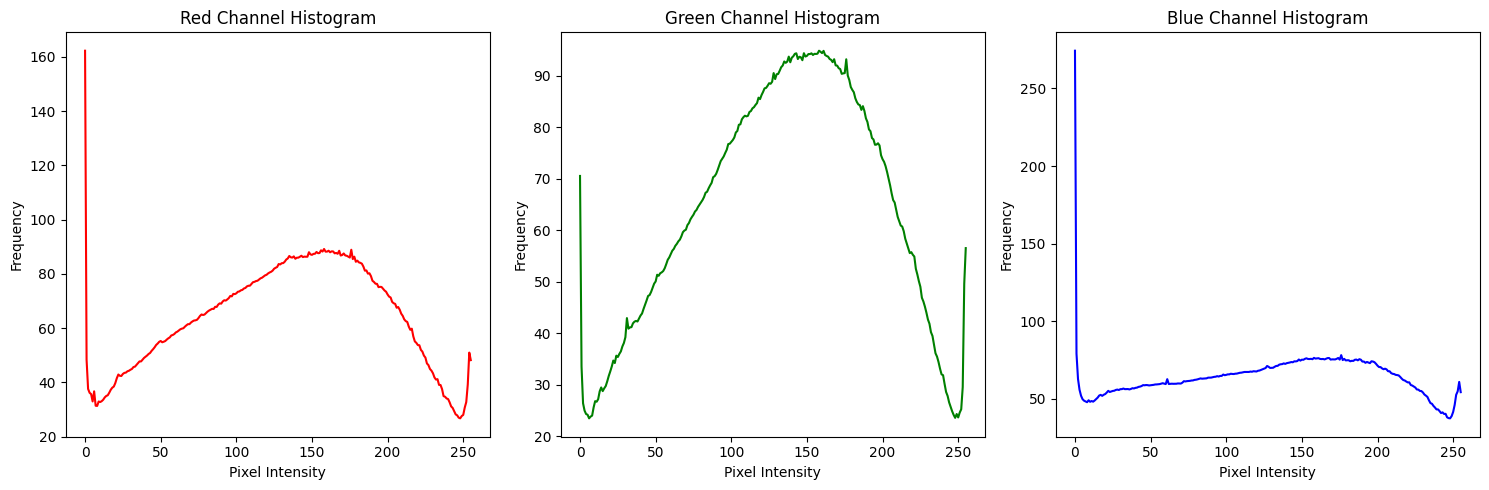

In [10]:
red_histograms = []
green_histograms = []
blue_histograms = []

for images, labels in dataset:
    red_hist, green_hist, blue_hist = extract_color_histograms(images)
    red_histograms.extend(red_hist)
    green_histograms.extend(green_hist)
    blue_histograms.extend(blue_hist)

# Plotting color histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Red Channel Histogram')
plt.plot(np.mean(red_histograms, axis=0), color='red')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.title('Green Channel Histogram')
plt.plot(np.mean(green_histograms, axis=0), color='green')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.title('Blue Channel Histogram')
plt.plot(np.mean(blue_histograms, axis=0), color='blue')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [11]:
def calculate_image_metrics(image):
    image = image.numpy().astype(np.uint8)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    brightness = np.mean(gray)
    
    laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
    sharpness = laplacian
    
    return brightness, sharpness

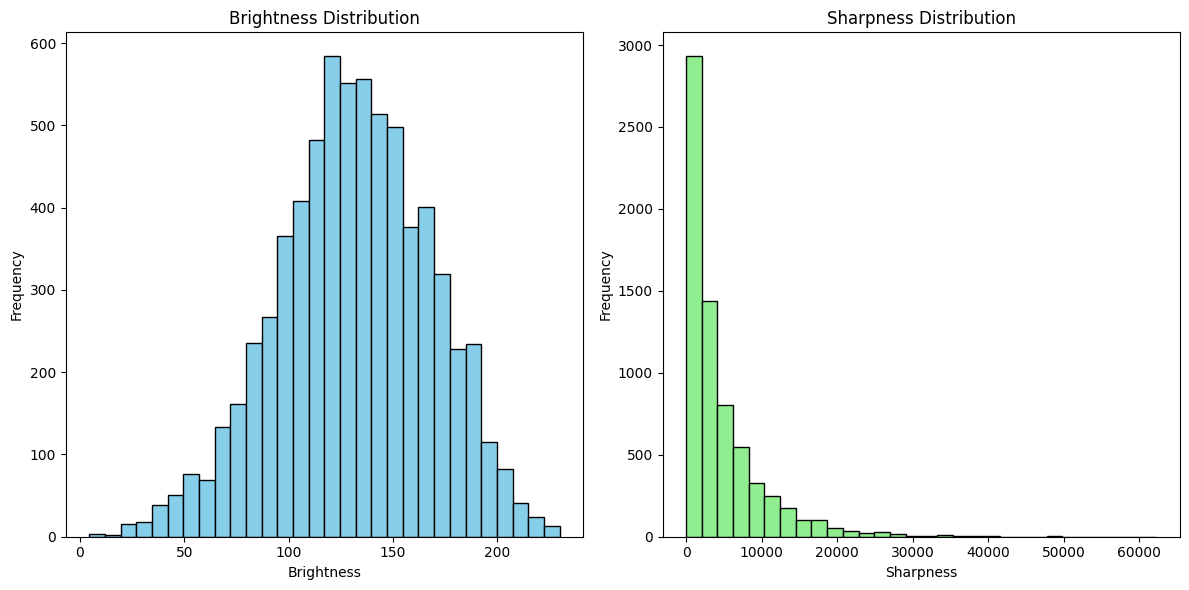

In [12]:
brightness_values = []
sharpness_values = []

for images, labels in dataset:
    for image in images:
        brightness, sharpness = calculate_image_metrics(image)
        brightness_values.append(brightness)
        sharpness_values.append(sharpness)

# Plotting image quality metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(brightness_values, bins=30, color='skyblue', edgecolor='black')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sharpness_values, bins=30, color='lightgreen', edgecolor='black')
plt.title('Sharpness Distribution')
plt.xlabel('Sharpness')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<div style="background-color: #00BFFF; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  ⚙️ Preprocessing
</div>

> **I believe class imbalance can be tackled by finding class weights**

In [13]:
labels = []
for image, label in dataset:
    labels.extend(label.numpy())
labels = np.array(labels)
labels = labels.astype(int)  
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [14]:
num_classes = 11
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_dataset = val_dataset.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [15]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

def preprocess_image(image, label):
    image = data_augmentation(image)
    image = Rescaling(1./255)(image)  
    return image, label

In [16]:
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (Rescaling(1./255)(x), y), num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

<div style="background-color: #00CED1; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🛠️ Custom Model
</div>

In [17]:
def swish_activation(x):
    return x * tf.sigmoid(x)

In [18]:
my_model = Sequential()

# Convolutional Block 1
my_model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3), kernel_initializer=HeNormal()))
my_model.add(Lambda(swish_activation))
my_model.add(BatchNormalization())
my_model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(Lambda(swish_activation))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Convolutional Block 2
my_model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(Lambda(swish_activation))
my_model.add(BatchNormalization())
my_model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(Lambda(swish_activation))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Convolutional Block 3
my_model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(Lambda(swish_activation))
my_model.add(BatchNormalization())
my_model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(Lambda(swish_activation))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Convolutional Block 4
my_model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(Lambda(swish_activation))
my_model.add(BatchNormalization())
my_model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(Lambda(swish_activation))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Global Average Pooling instead of Flatten
my_model.add(GlobalAveragePooling2D())

# Fully Connected Layers
initializer = HeNormal()
my_model.add(Dense(512, activation=swish_activation, kernel_initializer=initializer))
my_model.add(Dropout(0.5))
my_model.add(Dense(256, activation=swish_activation, kernel_initializer=initializer))
my_model.add(Dropout(0.5))
my_model.add(Dense(128, activation=swish_activation, kernel_initializer=initializer))
my_model.add(Dropout(0.5))

# Output Layer
my_model.add(Dense(11, activation='softmax', kernel_initializer=initializer))

# Compile the model
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

my_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,16

 Total params: 1,473,323 (5.62 MB)

 Trainable params: 1,471,403 (5.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
history = my_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    class_weight=class_weights,
)

Epoch 1/50


2024-06-20 11:31:50.428457: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2175: 3.31527, expected 2.86333
2024-06-20 11:31:50.428540: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8832: 3.04387, expected 2.59193
2024-06-20 11:31:50.428550: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8960: 3.285, expected 2.83305
2024-06-20 11:31:50.428561: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9600: 3.16471, expected 2.71277
2024-06-20 11:31:50.428579: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12032: 3.08921, expected 2.63726
2024-06-20 11:31:50.428601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15360: 3.30205, expected 2.8501
2024-06-20 11:31:50.428711: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32768: 4.65504, expected 3.81534
2024-06-20 11:31:50.428728: E exte

  3/172 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.0764 - loss: 4.7731  

I0000 00:00:1718883121.147480     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2398 - loss: 2.8591

2024-06-20 11:32:21.883119: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16384: 3.38606, expected 2.70678
2024-06-20 11:32:21.883175: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16387: 5.3662, expected 4.68692
2024-06-20 11:32:21.883184: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16388: 4.88003, expected 4.20075
2024-06-20 11:32:21.883192: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16389: 4.85563, expected 4.17635
2024-06-20 11:32:21.883200: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16390: 4.11805, expected 3.43877
2024-06-20 11:32:21.883208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16391: 4.022, expected 3.34272
2024-06-20 11:32:21.883222: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16392: 4.20981, expected 3.53053
2024-06-20 11:32:21.883230: E 

172/172 ━━━━━━━━━━━━━━━━━━━━ 43s 130ms/step - accuracy: 0.2405 - loss: 2.8530 - val_accuracy: 0.1642 - val_loss: 2.8350
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.4124 - loss: 1.8216 - val_accuracy: 0.3866 - val_loss: 1.8538
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.4512 - loss: 1.6341 - val_accuracy: 0.4845 - val_loss: 1.4445
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.4795 - loss: 1.5642 - val_accuracy: 0.4654 - val_loss: 1.4756
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.5092 - loss: 1.4571 - val_accuracy: 0.3940 - val_loss: 1.9781
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.5156 - loss: 1.4161 - val_accuracy: 0.4418 - val_loss: 1.5134
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.5384 - loss: 1.3855 - val_accuracy: 0.4455 - val_loss: 1.6893
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.5408 - loss: 1.3634 - val

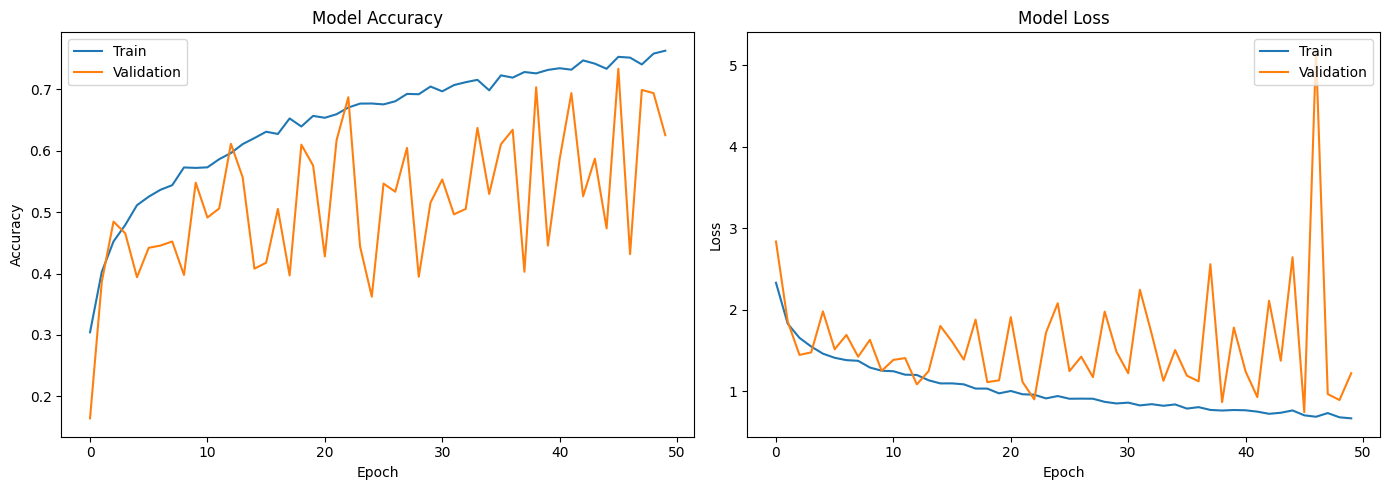

In [20]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

<div style="background-color: #20B2AA; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🔧 Fine-Tuning
</div>

In [24]:
my_model = Sequential()

# Convolutional Block 1
my_model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3), kernel_initializer=HeNormal()))
my_model.add(BatchNormalization())
my_model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Convolutional Block 2
my_model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(BatchNormalization())
my_model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Convolutional Block 3
my_model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(BatchNormalization())
my_model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Convolutional Block 4
my_model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(BatchNormalization())
my_model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer=HeNormal()))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Global Average Pooling instead of Flatten
my_model.add(GlobalAveragePooling2D())

# Additional Fully Connected Layers with Dropout and L2 Regularization
initializer = HeNormal()
my_model.add(Dense(512, activation='relu', kernel_initializer=initializer, kernel_regularizer=l2(0.01)))
my_model.add(Dropout(0.5))
my_model.add(Dense(256, activation='relu', kernel_initializer=initializer, kernel_regularizer=l2(0.01)))
my_model.add(Dropout(0.5))
my_model.add(Dense(128, activation='relu', kernel_initializer=initializer, kernel_regularizer=l2(0.01)))
my_model.add(Dropout(0.5))

# Output Layer
my_model.add(Dense(11, activation='softmax', kernel_initializer=initializer))

# Compile the model
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
my_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             

 Total params: 1,473,323 (5.62 MB)

 Trainable params: 1,471,403 (5.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [25]:
history = my_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    class_weight=class_weights,
)

Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 35s 122ms/step - accuracy: 0.1869 - loss: 19.0798 - val_accuracy: 0.3328 - val_loss: 12.6625
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.3327 - loss: 11.3512 - val_accuracy: 0.4359 - val_loss: 7.3794
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.3900 - loss: 6.7249 - val_accuracy: 0.4146 - val_loss: 4.6737
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.4287 - loss: 4.2186 - val_accuracy: 0.4455 - val_loss: 3.0652
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.4409 - loss: 2.9305 - val_accuracy: 0.4374 - val_loss: 2.3239
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.4531 - loss: 2.3563 - val_accuracy: 0.4728 - val_loss: 1.9792
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.4619 - loss: 2.0192 - val_accuracy: 0.4558 - val_loss: 1.8981
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.4545 - loss

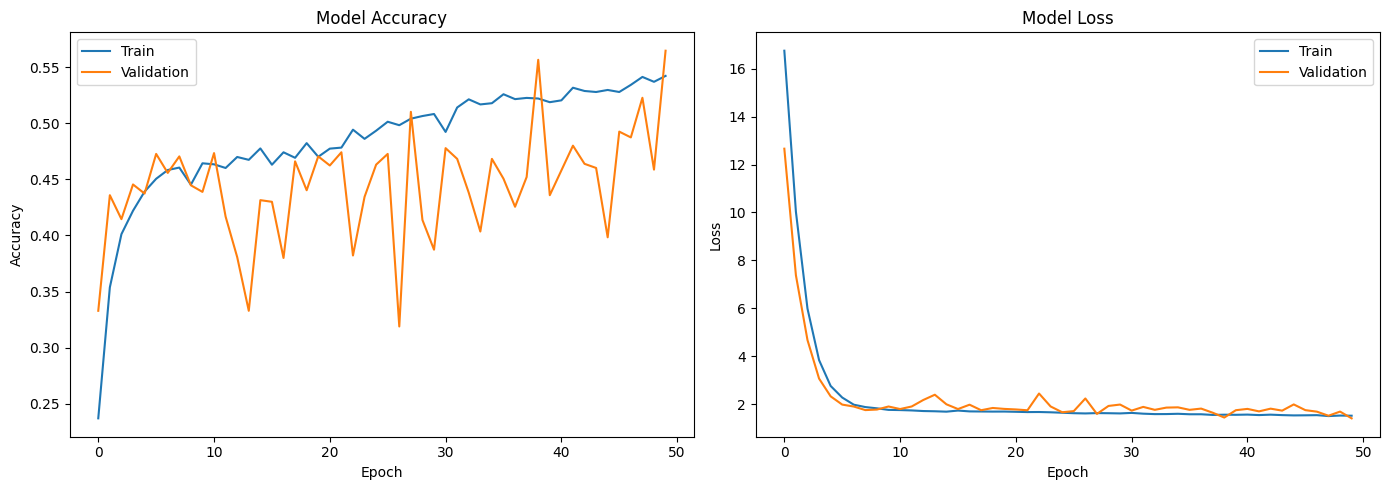

In [26]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

<div style="background-color: #5F9EA0; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🔄 Transfer Learning
</div>

In [28]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the base model layers
for layer in base_model_vgg16.layers:
    layer.trainable = False

#new model on top
model_vgg16 = Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(GlobalAveragePooling2D())
model_vgg16.add(Dense(512, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(128, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(11, activation='softmax'))

model_vgg16.compile(optimizer=Adam(learning_rate=0.0012), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg16.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model_vgg16.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    class_weight=class_weights,
)

Epoch 1/50


2024-06-20 12:25:28.687364: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.34782, expected 3.51669
2024-06-20 12:25:28.687434: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.71977, expected 5.88864
2024-06-20 12:25:28.687446: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.95696, expected 6.12583
2024-06-20 12:25:28.687459: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48105, expected 5.64992
2024-06-20 12:25:28.687474: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.32797, expected 4.49684
2024-06-20 12:25:28.687490: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.7497, expected 4.91857
2024-06-20 12:25:28.687500: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.01592, expected 5.18479
2024-06-20 12:25:28.687511: E external/local_xla/xla/ser

171/172 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.0935 - loss: 2.5883

2024-06-20 12:25:57.477487: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.35343, expected 3.47357
2024-06-20 12:25:57.477550: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.99384, expected 5.11397
2024-06-20 12:25:57.477560: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.60323, expected 5.72337
2024-06-20 12:25:57.477568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.4805, expected 5.60063
2024-06-20 12:25:57.477576: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37986, expected 4.5
2024-06-20 12:25:57.477584: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.45361, expected 4.57374
2024-06-20 12:25:57.477592: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.86515, expected 3.98529
2024-06-20 12:25:57.477600: E external/local_xla/xla/service

172/172 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.0935 - loss: 2.5874 - val_accuracy: 0.1495 - val_loss: 2.3830
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.1229 - loss: 2.4037 - val_accuracy: 0.3144 - val_loss: 2.3338
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.1430 - loss: 2.3396 - val_accuracy: 0.3284 - val_loss: 2.2301
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.1720 - loss: 2.2554 - val_accuracy: 0.3380 - val_loss: 2.0808
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.2143 - loss: 2.1306 - val_accuracy: 0.3689 - val_loss: 1.9239
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - accuracy: 0.2740 - loss: 2.0192 - val_accuracy: 0.4197 - val_loss: 1.7946
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.3057 - loss: 1.9142 - val_accuracy: 0.4713 - val_loss: 1.6447
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.3642 - loss: 1.7659 - val

<div style="background-color: #4682B4; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  📊 Comparison and Evaluation
</div>

<div style="background-color: #4169E1; padding: 20px; border-radius: 15px; border-top-right-radius: 50px; border-bottom-left-radius: 50px; text-align: center; font-size: 2em; font-weight: bold; color: #FFFFFF;">
  🏁 Conclusion
</div>